## 평가
머신러닝 모델은 여러 가지 방법으로 예측 성능을 평가할 수 있다.

    [성능 평가 지표]
    - 회귀: 예측 오차를 가지고 정규화 수준을 재가공하는 방법이 대표적
    - 분류(이진분류): 정확도 / 오차행렬 / 정밀도 / 재현율 / F1 스코어 / ROC AUC

### 전처리

In [39]:
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 피처 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Sex', 'Cabin', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

### 정확도 (Accuracy)
실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표

    정확도: 올바르게 예측한 데이터 건수 / 전체 예측 데이터 건수

단, 이진 분류의 경우 데이터 구성에 따라 ML 모델의 성능을 왜곡할 수 있기 때문에 정확도 수치 하나만 가지고 성능을 평가하지 않는다 !

#### 이진 분류에서 정확도만 가지고 성능을 평가하는 것의 오류
- 불균형한 레이블 세트에서는 정확도만으로 성능을 평가해서는 안된다 !

##### 예시 1
    여성 탑승객이 남성 탑승객에 비해 생존 확률이 높다

    -> 성별 조건 하나만으로 예측하는 알고리즘
    -> 여성 Survived (1) / 남성 Death (0)

In [40]:
import numpy as np
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # fit() 메서드는 아무것도 학습하지 않음.
    def fit(self, X, y=None):
        pass
    # predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함.
    def predict(self, X):
        pred = np.zeros( (X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] ==1: # male > Death
                pred[i] = 0
            else:                    # female > Survived
                pred[i] = 1

        return pred

In [41]:
# 타이타닉 생존자 예측 수행
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습/테스트 데이터 분할.
titanic_df = pd.read_csv('/content/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                    test_size=0.2, random_state=0)

# 위에서 생성한 DummyClassifier를 이용해 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('myDummyClassifier의 정확도는 {0:4f}'.format(accuracy_score(y_test, mypredictions)))

myDummyClassifier의 정확도는 0.787709


In [42]:
# 약 78.77%의 높은 정확도 !
# 정확도는 불균형한 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 적합한 평가 지표가 아님 !

##### 예시 2
    MNIST 데이터: 0~9 숫자 이미지의 픽셀 정보 데이터
    -> 숫자 Digit를 예측하는데 이용

    => 레이블 값이 7인 것만 True (10%), 나머지 값은 모두 False (90%)로 분류하는 이진 분류 문제


In [43]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

In [44]:
class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass

    # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros( (len(X), 1), dtype=bool)

# 사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환
y = (digits.target==7).astype(int) # (boolean).astype(int) = 0 또는 1
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [45]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64


In [46]:
# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는 {0:4f}'.format(accuracy_score(y_test, fakepred)))

모든 예측을 0으로 하여도 정확도는 0.900000


In [47]:
# 모든 예측을 0으로 하여도 정확도는 90%로 높다
## 이러한 한계점을 극복하기 위해 여러 가지 분류 지표와 함께 적용하여 성능을 평가해야 함 !

### 오차 행렬 (혼동 행렬)
    이진 분류의 예측 오류가 얼마인지 + 어떠한 유형의 예측 오류가 발생하고 있는지

    - 앞 문자 True/False : 예측값과 실제값이 '같은가/틀린가'
    - 뒤 문자 Positive/Negative : 예측 결과 값이 '부정(0)/긍정(1)'
    => TN  FP
       FN  TP
    
    - 불균형한 레이블 클래스를 가지는 이진 분류 모델에서는 중점적으로 찾아야 하는 매우 적은 수의 결과값 -> Positive(1)

    이를 다양하게 결합해 정확도 / 정밀도 / 재현율 / F1 스코어 계산

    * 정확도 = (TP + TN) / (TP + FP + TP + TN)

In [48]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]])

In [49]:
# 모두 7이 아니라고 예측 (450)
# 7이 아닌 digit (405) / 7인 digit (45)

### 정밀도와 재현율
#### 정밀도 (양성 예측도)
    예측을 Positive로 한 대상 중, 예측과 실제 값이 Positive로 일치한 데이터의 비율
    => TP / (TP + FP)

#### 재현율 (민감도, TPR)
    실제 값이 Positive인 대상 중, 예측과 실제 값이 Positive로 일치한 데이터의 비율
    => TP / (TP + FN)

    

In [50]:
# 정밀도와 재현율 모두 TP를 낮추는 것을 목표로 하지만,
# 정밀도는 FP를 낮추는 데, 재현율은 FN을 낮추는 것을 목표로 한다 !

In [51]:
# 타이타닉 생존자 예측 > 로지스틱 회귀 모형의 성능은 ?
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:4f}, 정밀도: {1:4f}, 재현율: {2:4f}'.format(accuracy, precision, recall))

In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('/content/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                    test_size=0.2, random_state=11)
lr_clf = LogisticRegression(solver='liblinear') # 로지스틱 회귀의 최적화 알고리즘 유형
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.865922, 정밀도: 0.824561, 재현율: 0.770492


### 정밀도/재현율 트레이드 오프
- 분류의 결정 임곗값(Threshold)을 조정해 정밀도 또는 재현율의 수치를 높일 수 있다
- 다만, 정밀도와 재현율은 상호 보완적인 지표이므로 Trade-off 관계를 가진다 !
- 일반적으로 이진 분류에서는 0.5를 임곗값으로 결정한다.
        0.5 보다 크면 Positive
        0.5보다 작으면 Negative
- predict_proba(): 개별 데이터별로 예측 확률을 반환 & predict() 기반

In [53]:
# predict_proba(): 타이타닉 생존자 예측 > 로지스틱 회귀
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba 결과 shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array와 예측 결과값 array를 병합(concatenate)해 예측 확률과 결과값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba 결과 shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.44935227 0.55064773]
 [0.86335512 0.13664488]
 [0.86429645 0.13570355]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.44935227 0.55064773 1.        ]
 [0.86335512 0.13664488 0.        ]
 [0.86429645 0.13570355 0.        ]]


In [54]:
# predict() 메서드는 predict_proba() 메서드에 기반해 생성된 API
# predict_proba() 결과로 반환된 배열에서 분류 결정 임계값보다 큰 값이 들어 있는 칼럼의 위치를 받아 최종적으로 예측 클래스를 결정

In [55]:
# 분류 결정 임곗값을 조절하면 정밀도와 재현율의 트레이드-오프 관계 확인
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
     [2, 0, 0],
     [0, 1.1, 1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [56]:
# 타이타닉 생존자 예측 > 로지스틱 회귀 > Binarizer 적용
from sklearn.preprocessing import Binarizer

# Birnarizer의 threshold 설정값
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)


오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.865922, 정밀도: 0.824561, 재현율: 0.770492


In [57]:
## 분류 결정 임곗값 조정 (정밀도와 재현율의 트레이드-오프 관계)
# 임곗값을 낮추면? Positive 예측 확률 높아짐 > 재현율 높아지고 정밀도는 낮아짐
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[97 21]
 [11 50]]
정확도: 0.821229, 정밀도: 0.704225, 재현율: 0.819672


In [58]:
# 임곗값을 0.4~0.6 조정 (간격: 0.05)
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 iteration하면서 Evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값: ', custom_threshold)
        get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1,1), thresholds)

임곗값:  0.4
오차 행렬
[[97 21]
 [11 50]]
정확도: 0.821229, 정밀도: 0.704225, 재현율: 0.819672
임곗값:  0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도: 0.854749, 정밀도: 0.786885, 재현율: 0.786885
임곗값:  0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.865922, 정밀도: 0.824561, 재현율: 0.770492
임곗값:  0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도: 0.871508, 정밀도: 0.865385, 재현율: 0.737705
임곗값:  0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도: 0.877095, 정밀도: 0.897959, 재현율: 0.721311


#### precision_recall_curve()
    0.11 ~ 0.95 정도의 임곗값을 담은 넘파이 ndarray와 그에 해당하는 정밀도, 재현율 값을 담은 넘파이 ndarray 반환

    - 인자: 실제 값 데이터 세트, 레이블 값이 1일 때의 예측 확률값 pred_proba(X_test)[:,1]



In [59]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

# precision_recall_curve()
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)
print(thresholds[:5])

# 반환된 임곗값 배열 로우 147건 > 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15) # 0 15 30 45 50 75 90 105 120 135
print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도:', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율:', np.round(recalls[thr_index], 3))



반환된 분류 결정 임곗값 배열의 Shape: (165,)
[0.01974988 0.06956414 0.08402808 0.08474207 0.08920161]
샘플 추출을 위한 임곗값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임곗값:  [0.02 0.11 0.13 0.14 0.16 0.24 0.32 0.45 0.62 0.73 0.87]
샘플 임계값별 정밀도: [0.341 0.372 0.401 0.44  0.505 0.598 0.688 0.774 0.915 0.968 0.938]
샘플 임계값별 재현율: [1.    1.    0.967 0.902 0.902 0.902 0.869 0.787 0.705 0.492 0.246]


In [60]:
# 임곗값 증가할수록, 정밀도는 높아지고 재현율은 낮아진다 !

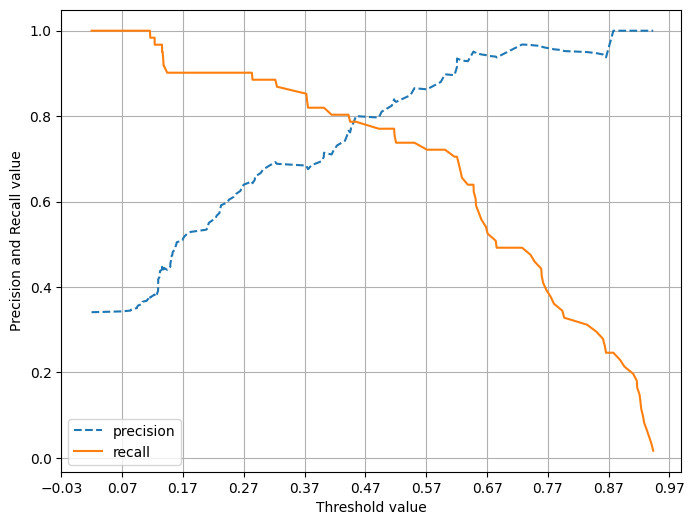

In [61]:
# 정밀도와 재현율 곡선
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    # X축을 threshold 값으로, Y축은 정밀도, 재현율 값으로 각각 plot 수행 (점선으로 표시)
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

    # threshold 값 X축의 Scale을 0, 1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

In [62]:
# 임곗값이 약 0.45 지점에서 재현율과 정밀도가 비슷해짐

### 정밀도와 재현율의 맹점
    정밀도와 재현율은 상호 보완적인 지표
    -> 단순히 하나의 성능 지표 수치를 높이기 위한 수단으로 사용돼서는 안 됨 !


### F1 스코어
    정밀도와 재현율을 결합한 지표
    -> 정밀도와 재현율이 어느 한 쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값

    F1 = 2 * (precision * recall) / (precision + recall)

In [63]:
# 타이타닉 생존자 예측 - 로지스틱 회귀 알고리즘의 F1 스코어
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred) # pred = lr_clf.predict(X_test)
print('F1 스코어: {0:4f}'.format(f1))

F1 스코어: 0.796610


In [64]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)

    # F1 스코어 추가
    f1 = f1_score(y_test, pred)

    print('오차 행렬')
    print(confusion)

    # f1 score print 추가
    print('정확도: {0:4f}, 정밀도: {1:4f}, 재현율: {2:4f}, F1: {3:4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값:  0.4
오차 행렬
[[97 21]
 [11 50]]
정확도: 0.821229, 정밀도: 0.704225, 재현율: 0.819672, F1: 0.757576
임곗값:  0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도: 0.854749, 정밀도: 0.786885, 재현율: 0.786885, F1: 0.786885
임곗값:  0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.865922, 정밀도: 0.824561, 재현율: 0.770492, F1: 0.796610
임곗값:  0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도: 0.871508, 정밀도: 0.865385, 재현율: 0.737705, F1: 0.796460
임곗값:  0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도: 0.877095, 정밀도: 0.897959, 재현율: 0.721311, F1: 0.800000


### ROC 곡선과 AUC
    - TPR (True Positive Rate) = TP / (TP + FN) : 실제값 Positive가 정확히 예측돼야 하는 수준(재현율)
    - TNR (True Negative Rate) = TN / (TN + FP) : 실제값 Negative가 정확히 예측돼야 하는 수준(특이성)
    - FPR (False Positive Rate) = FP / (FP + TN) : 실제값 Negative를 Positive로 잘못 예측하는 수준
    - FNR (False Negative Rate) = FN / (FN + TP) : 실제값 Positive를 Negative로 잘못 예측하는 수준

#### ROC (Receiver Operation Curve)
    : FPR이 변할 때 TPR이 어떻게 변하는지 나타내는 곡선

    - 가운데 직선 (ROC 곡선의 최저 값)에 가까울수록 성능이 떨어짐

#### AUC (Area Under Curve)
    : ROC 곡선 밑의 면적
    
    - 일반적으로 1에 가까울수록 좋은 수치
    - 분류의 성능 지표로 이용
    - 가운데 직선은 랜덤 수준의 이진 분류 AUC 값으로 0.5

#### roc_curve()
    # 입력 파라미터
    - y_true: 실제 클래스 값 array
    - y_score: predict_proba() Positive 칼럼의 예측 확률

    # 반환값
    - fpr
    - tpr
    - thresholds

In [65]:
## 분류 결정 임곗값을 변경하며 FPR을 0~1까지 변경
# if 임곗값 1, FP = 0 -> FPR = 0
# if 임곗값 0, TN = 0 -> FPR = 1

In [66]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일 때의 예측 확률 pred_proba_class1
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

In [67]:
# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 Step으로 추출
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
print(thresholds)

[1.94326279 0.94326279 0.94040086 0.93261004 0.87778554 0.86565305
 0.72771397 0.68584876 0.64779432 0.63856712 0.626297   0.62067108
 0.61651658 0.60096648 0.57135185 0.55064773 0.52051722 0.51724751
 0.4920994  0.45447199 0.4449725  0.44222428 0.41445141 0.40194454
 0.37571831 0.32202997 0.28441583 0.283459   0.23280097 0.22996172
 0.14927476 0.14927301 0.14423594 0.13866562 0.13821236 0.13664488
 0.13574048 0.13570998 0.13196917 0.1317437  0.12941901 0.12934055
 0.1290451  0.12350957 0.12349478 0.11636721 0.11573102 0.01974988]


In [68]:
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값:', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR:', np.round(fprs[thr_index], 3))
print('샘플 임계값별 TPR:', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46]
샘플 index로 추출한 임곗값: [0.94 0.73 0.62 0.52 0.44 0.28 0.15 0.14 0.13 0.12]
샘플 임곗값별 FPR: [0.    0.008 0.025 0.076 0.127 0.254 0.576 0.61  0.746 0.847]
샘플 임계값별 TPR: [0.016 0.492 0.705 0.738 0.803 0.885 0.902 0.951 0.967 1.   ]


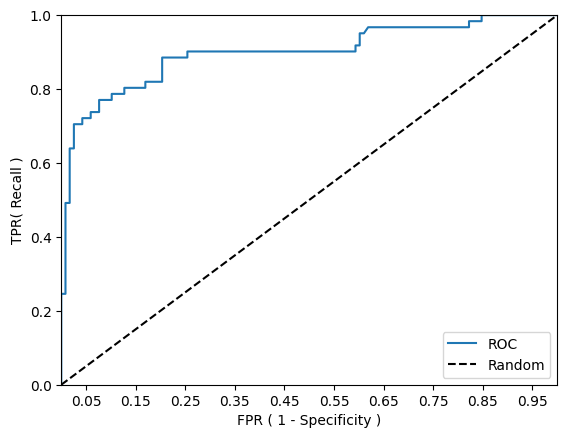

In [69]:
# FPR 변화에 따른 TPR의 변화를 ROC 곡선으로 시각화
def roc_curve_plot(y_test, pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값 반환
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # ROC 곡선
    plt.plot(fprs, tprs, label='ROC')
    # 가운데 직선
    plt.plot([0,1], [0,1], 'k--', label='Random')

    # FPR 축의 Scale을 0.1 단위로 변경, X, Y축명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR ( 1 - Specificity )'); plt.ylabel('TPR( Recall )')
    plt.legend()

roc_curve_plot(y_test, pred_proba[:,1])

In [70]:
# AUC
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:4f}'.format(roc_score))

ROC AUC 값: 0.898652


In [71]:
## get_clf_eval() 재정의
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    # ROC AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)

    print('오차 행렬')
    print(confusion)

    print('정확도: {0:4f}, 정밀도: {1:4f}, 재현율: {2:4f}, \
        F1: {3:4f}, AUC: {4:4f}'.format(accuracy, precision, recall, f1, roc_auc))

### 피마 인디언 당뇨병 예측
피마 인디언 당뇨병 데이터 세트를 이용해 당뇨병 여부를 판단하는 머신러닝 예측 모델을 수립하고, 평가 지표를 적용해보자 !

    - Pregnancies : 임신 횟수
    - Glucose : 포도당 부하 검사 수치
    - BloodPressure : 혈압
    - SkinThickness : 팔 삼두근 뒤쪽의 피하지방 측정값
    - Insulin : 혈청 인슐린
    - BMI : 체질량 지수
    - DiabetesPedigreeFunction : 당뇨 내력 가중치 값
    - Age : 나이
    - Outcome : 클래스 결정 값 (0 또는 1)

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('/content/diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [73]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [74]:
## 1. 데이터 전처리
# 모두 숫자형 피처 > 별도의 피처 인코딩 불필요

In [75]:
## 2. 로지스틱 회귀를 이용한 예측 모델 생성
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출
# 맨 끝이 Outcome 칼럼으로 레이블 값임. 칼럼 위치 -1을 이용해 추출
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, \
                                                    random_state=156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[87 13]
 [22 32]]
정확도: 0.772727, 정밀도: 0.711111, 재현율: 0.592593,         F1: 0.646465, AUC: 0.808333


In [76]:
## 전체 데이터의 65%가 Negative이므로 정확도보다는 재현율의 성능에 더 초점

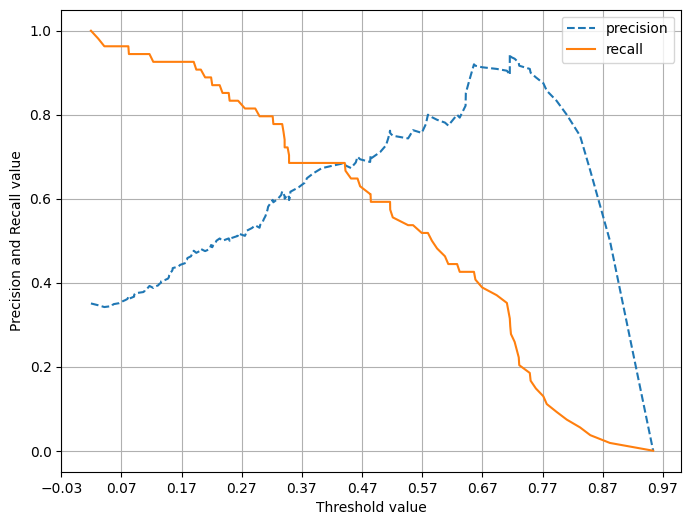

In [77]:
# 정밀도 재현율 곡선 > 임곗값별 정밀도와 재현율 값의 변화
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test, pred_proba_c1)

- 임곗값을 0.42 정도로 낮추면, 정밀도와 재현율이 어느 정도 균형을 맞출 것 같다.

- 하지만, 두 개 지표 모두 0.7이 안되는 수치로 낮다.

        임곗값을 인위적으로 조작하기 전에, 다시 데이터 값을 점검해 보자 !

In [78]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [79]:
# min() 값이 0으로 돼 있는 피처가 상당히 많다
# Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin
# Glucose 피처 (포도당 수치) : min 값이 0인 것은 말이 되지 않는다.

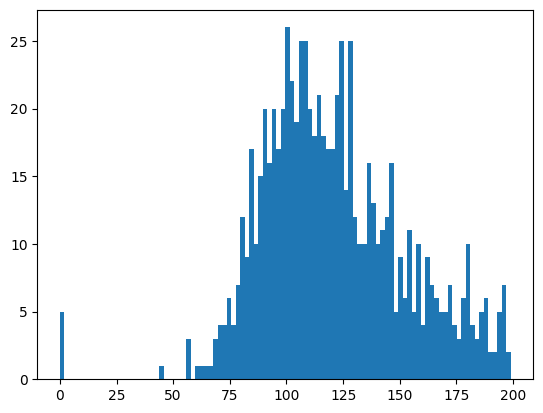

In [80]:
# Glucose 피처 0값 5개 존재
plt.hist(diabetes_data['Glucose'], bins=100)
plt.show()

In [81]:
# 0값을 검사할 피처명 리스트
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count() # diabetes_data.shape[0]

# 피처별로 반복하면서 데이터 값이 0인 데이터 건수를 추출하고, 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature]==0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:2f} %'.format(feature, zero_count,
                                                100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.651042 %
BloodPressure 0 건수는 35, 퍼센트는 4.557292 %
SkinThickness 0 건수는 227, 퍼센트는 29.557292 %
Insulin 0 건수는 374, 퍼센트는 48.697917 %
BMI 0 건수는 11, 퍼센트는 1.432292 %


In [82]:
# SkinThickness 29.56%, Insulin 48.7%로 대단히 많다.
# 전체 데이터 건수가 많지 않으므로, 일괄 삭제할 경우 학습을 효과적으로 수행하기 어렵다.
# -> 위 피처의 0 값을 평균값으로 대체

In [83]:
# zero_features 리스트 내부에 저장된 개발 피처들에 대해 0값을 평균 값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, mean_zero_features)

In [84]:
# 피처 스케일링을 적용 후, 로지스틱 회귀를 적용
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)


오차 행렬
[[90 10]
 [21 33]]
정확도: 0.798701, 정밀도: 0.767442, 재현율: 0.611111,         F1: 0.680412, AUC: 0.843333


In [85]:
# 피처 스케일링 전 > 정확도: 0.772727, 정밀도: 0.711111, 재현율: 0.592593, F1: 0.646465, AUC: 0.808333
# 피처 스케일링 후 > 정확도: 0.798701, 정밀도: 0.767442, 재현율: 0.611111, F1: 0.680412, AUC: 0.843333

In [97]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    # ROC AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)

    print('오차 행렬')
    print(confusion)

    print('정확도: {0:4f}, 정밀도: {1:4f}, 재현율: {2:4f}, \
        F1: {3:4f}, AUC: {4:4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [98]:
from sklearn.preprocessing import Binarizer

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 iteration하면서 Evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값: ', custom_threshold)
        get_clf_eval(y_test, custom_predict, pred_proba_c1)

In [99]:
# 분류 결정 임곗값을 조정하며 재현율 값의 성능 수치가 어느 정도 개선되는지 확인
thresholds = [0.3, 0.33, 0.36, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)

get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1,1), thresholds)

임곗값:  0.3
오차 행렬
[[67 33]
 [11 43]]
정확도: 0.714286, 정밀도: 0.565789, 재현율: 0.796296,         F1: 0.661538, AUC: 0.843333
임곗값:  0.33
오차 행렬
[[72 28]
 [12 42]]
정확도: 0.740260, 정밀도: 0.600000, 재현율: 0.777778,         F1: 0.677419, AUC: 0.843333
임곗값:  0.36
오차 행렬
[[76 24]
 [15 39]]
정확도: 0.746753, 정밀도: 0.619048, 재현율: 0.722222,         F1: 0.666667, AUC: 0.843333
임곗값:  0.42
오차 행렬
[[84 16]
 [18 36]]
정확도: 0.779221, 정밀도: 0.692308, 재현율: 0.666667,         F1: 0.679245, AUC: 0.843333
임곗값:  0.45
오차 행렬
[[85 15]
 [18 36]]
정확도: 0.785714, 정밀도: 0.705882, 재현율: 0.666667,         F1: 0.685714, AUC: 0.843333
임곗값:  0.48
오차 행렬
[[88 12]
 [19 35]]
정확도: 0.798701, 정밀도: 0.744681, 재현율: 0.648148,         F1: 0.693069, AUC: 0.843333
임곗값:  0.5
오차 행렬
[[90 10]
 [21 33]]
정확도: 0.798701, 정밀도: 0.767442, 재현율: 0.611111,         F1: 0.680412, AUC: 0.843333


In [100]:
# 임곗값 0.48이 전체적인 성능 평가 지표를 유지하면서 재현율을 약간 향상시키는 좋은 임곗값 !
# 정확도 0.7987, 정밀도 0.7447, 재현율 0.6481, F1 스코어 0.6931, ROC AUC 0.8433

In [101]:
## 임곗값 0.48 > 로지스틱 회귀 재적용
# 임곗값을 0.48로 설정한 Binarizer 생성
from sklearn.preprocessing import Binarizer
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 칼럼값을 Binarizer 변환
pred_th_048 = binarizer.fit_transform(pred_proba[:,1].reshape(-1,1))

get_clf_eval(y_test, pred_th_048, pred_proba[:,1])

오차 행렬
[[88 12]
 [19 35]]
정확도: 0.798701, 정밀도: 0.744681, 재현율: 0.648148,         F1: 0.693069, AUC: 0.843333
